# Time Series Validation: Topic Attention in Earnings Calls

This notebook validates the semantic measurement pipeline by examining temporal patterns in three key topics:

1. **Climate Change / Energy Transition** - Expected spikes: Paris Agreement (2015), COP conferences
2. **Artificial Intelligence** - Expected spike: 2023 generative AI boom (ChatGPT, etc.)
3. **Geopolitical Risk** - Expected spikes: Brexit (2016), US-China trade war (2018-2019), Russia-Ukraine (2022)

## Setup

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Paths
data_dir = Path('../outputs/validation')
figures_dir = Path('../outputs/figures')
figures_dir.mkdir(parents=True, exist_ok=True)

## Load Data

In [18]:
# Load combined dataset
df = pd.read_parquet(data_dir / 'validation_topics_combined.parquet')

print(f"Total observations: {len(df):,}")
print(f"\nTopics: {df['topic'].unique()}")
print(f"\nYear range: {df['year'].min()} - {df['year'].max()}")
print(f"\nFirms: {df['ticker'].nunique()}")

df.head()

Total observations: 8,781

Topics: ['climate_energy_transition' 'artificial_intelligence' 'geopolitical_risk']

Year range: 2009 - 2025

Firms: 1079


,call_id,ticker,company_name,year,quarter,date,source_file,total_sentences,management_sentences,qa_sentences,...,qa_intensity,n_hits_total,n_hits_mgmt,n_hits_qa,sentences_total_hits,sentences_mgmt_hits,sentences_qa_hits,quarter_id,topic,topic_description
0,A_2011Q1_2011-02-14,A,"Agilent Technologies, Inc.",2011,Q1,2011-02-14,structured_calls_part1.json,522,107,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011Q1,climate_energy_transition,"Climate change, energy transition, and decarbo..."
1,A_2015Q1_2015-02-17,A,"Agilent Technologies, Inc. (A)",2015,Q1,2015-02-17,structured_calls_part1.json,495,143,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015Q1,climate_energy_transition,"Climate change, energy transition, and decarbo..."
2,A_2016Q3_2016-08-17,A,"Agilent Technologies, Inc. (A)",2016,Q3,2016-08-17,structured_calls_part1.json,561,129,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016Q3,climate_energy_transition,"Climate change, energy transition, and decarbo..."
3,A_2023Q2_2023-05-23,A,"Agilent Technologies, Inc. (A)",2023,Q2,2023-05-23,structured_calls_part1.json,571,147,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023Q2,climate_energy_transition,"Climate change, energy transition, and decarbo..."
4,A_2023Q3_2023-08-15,A,"Agilent Technologies, Inc. (A)",2023,Q3,2023-08-15,structured_calls_part1.json,604,156,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023Q3,climate_energy_transition,"Climate change, energy transition, and decarbo..."


## Data Preparation

In [19]:
# Create cleaner topic labels for plotting
topic_labels = {
    'climate_energy_transition': 'Climate Change / Energy Transition',
    'artificial_intelligence': 'Artificial Intelligence',
    'geopolitical_risk': 'Geopolitical Risk'
}

df['topic_label'] = df['topic'].map(topic_labels)

# Create quarter-year variable for finer time resolution
df['year_quarter'] = df['year'] + (df['quarter'].str.extract('(\d)')[0].astype(int) - 1) / 4

# Summary by topic
print("Summary by topic:")
print(df.groupby('topic_label').agg({
    'exposure': ['mean', 'std', 'median'],
    'n_hits_total': 'sum',
    'ticker': 'nunique'
}).round(4))

Summary by topic:
                                   exposure                 n_hits_total  \
                                       mean     std  median          sum   
topic_label                                                                
Artificial Intelligence              0.0556  0.0729  0.0240        327.0   
Climate Change / Energy Transition   0.0349  0.0486  0.0174       1567.0   
Geopolitical Risk                    0.0334  0.0361  0.0191        619.0   

                                    ticker  
                                   nunique  
topic_label                                 
Artificial Intelligence               1079  
Climate Change / Energy Transition    1079  
Geopolitical Risk                     1079  


## Time Series Aggregation

We compute aggregate exposure metrics by year and quarter.

In [20]:
# Annual aggregation
annual = df.groupby(['year', 'topic_label']).agg({
    'exposure': ['mean', 'median', 'std'],
    'intensity': ['mean', 'median'],
    'avgSim': 'mean',
    'n_hits_total': 'sum',
    'ticker': 'nunique',
    'call_id': 'count'
}).reset_index()

# Flatten column names
annual.columns = ['_'.join(col).strip('_') for col in annual.columns]

# Quarterly aggregation  
quarterly = df.groupby(['year_quarter', 'topic_label']).agg({
    'exposure': ['mean', 'median'],
    'intensity': 'mean',
    'n_hits_total': 'sum',
    'ticker': 'nunique'
}).reset_index()

quarterly.columns = ['_'.join(col).strip('_') for col in quarterly.columns]

print("Annual data shape:", annual.shape)
print("Quarterly data shape:", quarterly.shape)

Annual data shape: (51, 11)
Quarterly data shape: (195, 7)


## Plot 1: Annual Exposure Trends (All Topics)

Mean exposure by topic over time.

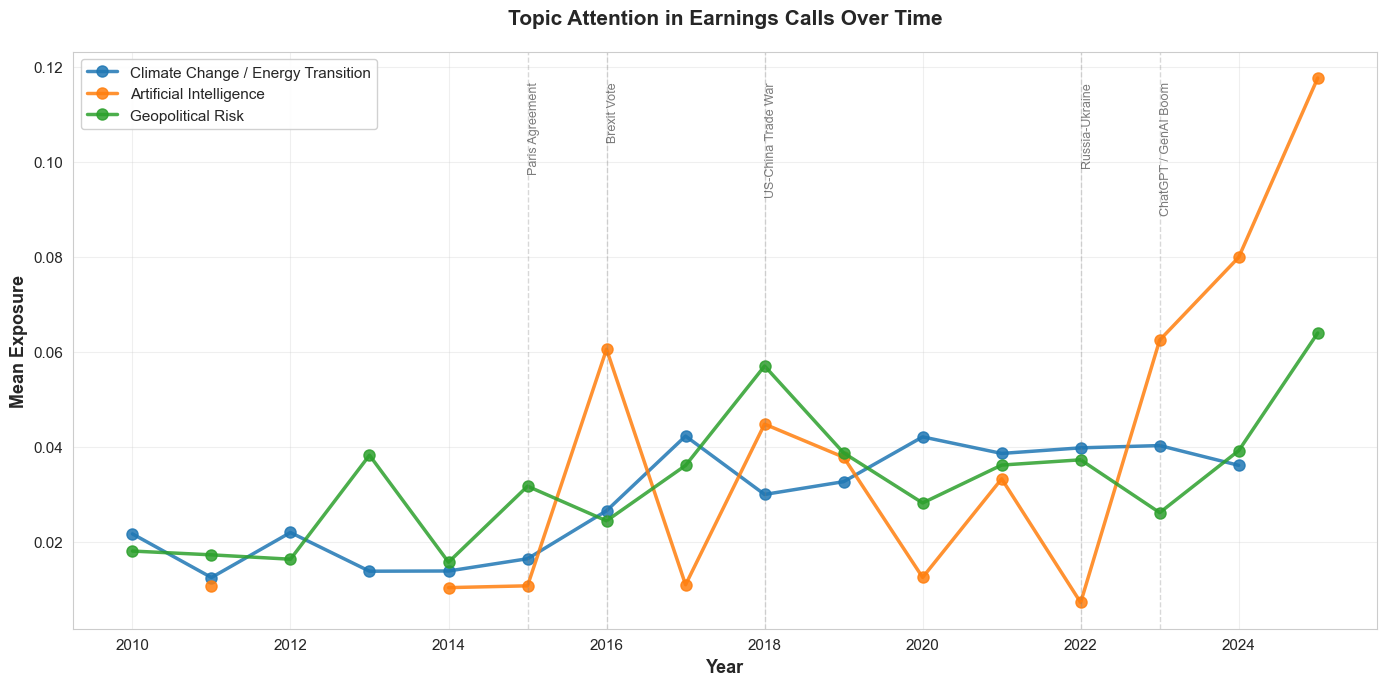

✓ Saved: ../outputs/figures/validation_annual_trends.png


In [21]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each topic
for topic in topic_labels.values():
    data = annual[annual['topic_label'] == topic]
    ax.plot(data['year'], data['exposure_mean'], 
            marker='o', linewidth=2.5, markersize=8,
            label=topic, alpha=0.85)

# Key events annotations
events = [
    (2015, 0.0, 'Paris Agreement', 'Climate Change / Energy Transition'),
    (2016, 0.0, 'Brexit Vote', 'Geopolitical Risk'),
    (2018, 0.0, 'US-China Trade War', 'Geopolitical Risk'),
    (2022, 0.0, 'Russia-Ukraine', 'Geopolitical Risk'),
    (2023, 0.0, 'ChatGPT / GenAI Boom', 'Artificial Intelligence'),
]

for year, _, label, _ in events:
    if year >= annual['year'].min() and year <= annual['year'].max():
        ax.axvline(year, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        ax.text(year, ax.get_ylim()[1] * 0.95, label, 
                rotation=90, verticalalignment='top',
                fontsize=9, alpha=0.6)

ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Exposure', fontsize=13, fontweight='bold')
ax.set_title('Topic Attention in Earnings Calls Over Time', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left', framealpha=0.9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'validation_annual_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {figures_dir / 'validation_annual_trends.png'}")

## Plot 2: Quarterly Trends (High Resolution)

Quarterly mean exposure for more granular temporal patterns.

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

topics = list(topic_labels.values())

for i, (ax, topic) in enumerate(zip(axes, topics)):
    data = quarterly[quarterly['topic_label'] == topic]
    
    ax.plot(data['year_quarter'], data['exposure_mean'], 
            linewidth=2, color=f'C{i}', alpha=0.7)
    ax.fill_between(data['year_quarter'], 0, data['exposure_mean'],
                     alpha=0.2, color=f'C{i}')
    
    # Add relevant event markers for each topic
    relevant_events = [e for e in events if e[3] == topic]
    for year, _, label, _ in relevant_events:
        if year >= data['year_quarter'].min() and year <= data['year_quarter'].max():
            ax.axvline(year, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
            ax.text(year + 0.1, ax.get_ylim()[1] * 0.9, label,
                   fontsize=9, color='red', fontweight='bold')
    
    ax.set_ylabel('Mean Exposure', fontsize=11, fontweight='bold')
    ax.set_title(topic, fontsize=12, fontweight='bold', pad=10)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel('Year', fontsize=12, fontweight='bold')

fig.suptitle('Quarterly Topic Attention Trends with Key Events', 
             fontsize=15, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig(figures_dir / 'validation_quarterly_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {figures_dir / 'validation_quarterly_trends.png'}")

## Plot 3: Share of Calls Mentioning Topic

Percentage of calls with non-zero exposure (at least one hit).

In [ ]:
# Compute share with hits by year
df['has_hits'] = df['n_hits_total'] > 0

share_with_hits = df.groupby(['year', 'topic_label']).agg({
    'has_hits': 'mean',
    'call_id': 'count'
}).reset_index()

share_with_hits.columns = ['year', 'topic_label', 'share_with_hits', 'n_calls']
share_with_hits['share_with_hits'] *= 100  # Convert to percentage

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

for topic in topic_labels.values():
    data = share_with_hits[share_with_hits['topic_label'] == topic]
    ax.plot(data['year'], data['share_with_hits'],
            marker='o', linewidth=2.5, markersize=8,
            label=topic, alpha=0.85)

# Event lines
for year, _, label, _ in events:
    if year >= share_with_hits['year'].min() and year <= share_with_hits['year'].max():
        ax.axvline(year, color='gray', linestyle='--', alpha=0.3, linewidth=1)

ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Share of Calls Mentioning Topic (%)', fontsize=13, fontweight='bold')
ax.set_title('Prevalence of Topic Mentions in Earnings Calls', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left', framealpha=0.9)
ax.grid(alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig(figures_dir / 'validation_share_mentioning.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {figures_dir / 'validation_share_mentioning.png'}")

## Plot 4: Intensity Metric

Exposure × Average Similarity (captures both volume and relevance)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

for topic in topic_labels.values():
    data = annual[annual['topic_label'] == topic]
    ax.plot(data['year'], data['intensity_mean'],
            marker='s', linewidth=2.5, markersize=8,
            label=topic, alpha=0.85)

# Event markers
for year, _, label, _ in events:
    if year >= annual['year'].min() and year <= annual['year'].max():
        ax.axvline(year, color='gray', linestyle='--', alpha=0.3, linewidth=1)
        ax.text(year, ax.get_ylim()[1] * 0.95, label,
                rotation=90, verticalalignment='top',
                fontsize=9, alpha=0.6)

ax.set_xlabel('Year', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Intensity (Exposure × AvgSim)', fontsize=13, fontweight='bold')
ax.set_title('Topic Intensity in Earnings Calls Over Time', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left', framealpha=0.9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'validation_intensity_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {figures_dir / 'validation_intensity_trends.png'}")

## Statistical Summary: Event Timing Validation

Check if exposure increases around expected events.

In [ ]:
def check_event_spike(df, topic, event_year, window=1):
    """
    Check if exposure increased around an event.
    
    Parameters:
        df: DataFrame with annual data
        topic: Topic label
        event_year: Year of event
        window: Years before/after to compare
    """
    data = df[df['topic_label'] == topic].copy()
    
    before = data[data['year'].between(event_year - window - 2, event_year - window - 1)]['exposure_mean'].mean()
    during = data[data['year'].between(event_year - window, event_year + window)]['exposure_mean'].mean()
    
    if pd.notna(before) and pd.notna(during):
        pct_change = ((during - before) / before) * 100 if before > 0 else np.nan
        return {
            'topic': topic,
            'event_year': event_year,
            'before': before,
            'during': during,
            'pct_change': pct_change
        }
    return None

# Check all events
validation_results = []

for year, _, label, topic in events:
    result = check_event_spike(annual, topic, year, window=1)
    if result:
        result['event'] = label
        validation_results.append(result)

validation_df = pd.DataFrame(validation_results)

print("\nEvent Validation Results:")
print("="*80)
print(validation_df.to_string(index=False))
print("\n" + "="*80)

# Summary
significant_increases = (validation_df['pct_change'] > 20).sum()
print(f"\nEvents with >20% exposure increase: {significant_increases}/{len(validation_df)}")

## Export Summary Tables

In [ ]:
# Annual summary for paper/presentation
summary_export = annual[[
    'year', 'topic_label', 'exposure_mean', 'intensity_mean', 
    'ticker_nunique', 'call_id_count'
]].copy()

summary_export.columns = [
    'Year', 'Topic', 'Mean Exposure', 'Mean Intensity',
    'N Firms', 'N Calls'
]

summary_export.to_csv(figures_dir / 'validation_summary_annual.csv', index=False)
print(f"\n✓ Saved summary table: {figures_dir / 'validation_summary_annual.csv'}")

# Event validation results
validation_df.to_csv(figures_dir / 'validation_event_checks.csv', index=False)
print(f"✓ Saved event validation: {figures_dir / 'validation_event_checks.csv'}")

## Interpretation Notes

### Expected Patterns:

**Climate Change / Energy Transition:**
- Should show gradual increase post-2015 (Paris Agreement)
- Possible acceleration around major climate events (wildfires, COP conferences)
- ESG investing mainstreaming (2018-2020)

**Artificial Intelligence:**
- Gradual increase through 2010s (ML adoption)
- Sharp spike in late 2022/early 2023 (ChatGPT/generative AI)
- Should be highest in tech sectors

**Geopolitical Risk:**
- Spikes around: Brexit (2016), US-China trade war (2018-2019), COVID-19 (2020), Russia-Ukraine (2022)
- More volatile than other topics (event-driven)

### Validation Criteria:

✅ **Pipeline is working well if:**
- Trends align with major real-world events
- Exposure changes are economically meaningful (not random noise)
- Different topics show distinct temporal patterns

⚠️ **Potential issues if:**
- No variation over time (suggests threshold too high/low)
- All topics move together (suggests not capturing distinct concepts)
- Spikes don't align with known events (suggests measurement error)